# 불균형 데이터 다뤄보기
## Kaggle - Credit Card Fraud Detection
[Kaggel - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)  
[참고 | 파이썬 머신러닝 완벽 강의 (권철민 저)]()  

## Under-Sampling and Over-Sampling
레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생 가능함  
제대로 다양한 유형을 학습하지 못하는 경우가 발생하기때문임  
지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요  
- 오버 샘플링(over-sampling): 적은 레이블을 증식, 예측 성능이 좋음
- 언더 샘플링(under-sampling): 많은 레이블을 적은 레이블 수준으로 감소

### 사용 라이브러리

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

### Confusion Matrix func.
Confusion Matrix를 이용해, 관련 정보를 출력해주는 함수

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def eval_CM(y_test, y_pred=None, pred_prob=None, show_cm=0):
    confusion = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pred_prob)
    if show_cm:
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}\nROC_AUC: {roc_auc:.4f}")
    else:
        print(confusion)
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}\nROC_AUC: {roc_auc:.4f}")
    return confusion, acc, precision, recall, f1, roc_auc

### Data Load

In [35]:
card_df = pd.read_csv("creditcard.csv")
card_df.shape

(284807, 31)

### EDA 및 전처리

In [3]:
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


`Time`의 경우 의미 없는 컬럼  
`Amount`는 트랜잭션 금액, `Class`는 레이블(예측해야하는 값)로 0=정상, 1=사기 트랜잭션

In [7]:
card_df.isnull().sum().sum()

0

결측치는 존재하지 않음

### Train 및 개선 (with LGBM)
#### Data Split

In [36]:
card_df.drop(columns="Time", axis=1, inplace=True)

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199364, 29)
y_train: (199364,)
X_test: (85443, 29)
y_test: (85443,)


In [9]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

0    0.998275
1    0.001725
Name: Class, dtype: float64

0    0.998268
1    0.001732
Name: Class, dtype: float64

`stratify` 옵션이 잘 적용된 모습을 볼 수 있음

#### 초기 성능
데이터 전처리마다 모델의 개선을 확인하기 위한 함수를 만듬  
굉장히 좋은 방법이라고 생각됨, 피처 엔지니어링이나 튜닝이 필요할 때 유용하게 사용할 수 있을꺼 같음

In [16]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None, cm=0):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    eval_CM(tgt_test, pred, pred_proba, cm)

In [17]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85293     2]
 [   41   107]]
정확도: 0.9995
정밀도: 0.9817
재현율: 0.7230
F1: 0.8327
ROC_AUC: 0.9708


#### 데이터 분포 변환
대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호

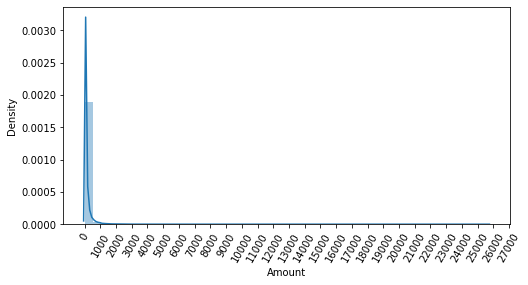

In [26]:
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
_ = sns.distplot(card_df["Amount"])

##### `Standard Scaler`을 이용해 정규화

In [31]:
scaler = StandardScaler()
amount_n = scaler.fit_transform(card_df["Amount"].values.reshape(-1, 1))
card_df["Amount"] = amount_n

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199364, 29)
y_train: (199364,)
X_test: (85443, 29)
y_test: (85443,)


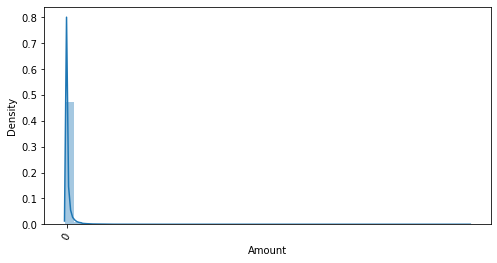

In [34]:
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
_ = sns.distplot(card_df["Amount"])

In [33]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85289     6]
 [   19   129]]
정확도: 0.9997
정밀도: 0.9556
재현율: 0.8716
F1: 0.9117
ROC_AUC: 0.9826


##### `log1p`를 이용한 정규화

In [38]:
card_df = pd.read_csv("creditcard.csv")

amount_n = np.log1p(card_df["Amount"])
card_df.drop(columns="Time", axis=1, inplace=True)
card_df["Amount"] = amount_n

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199364, 29)
y_train: (199364,)
X_test: (85443, 29)
y_test: (85443,)


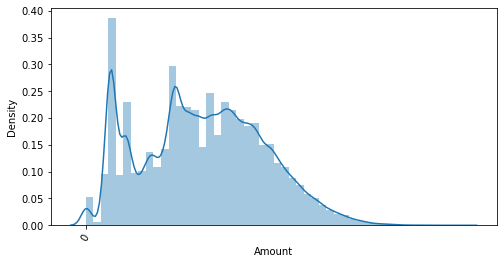

In [40]:
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
_ = sns.distplot(card_df["Amount"])

In [39]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85290     5]
 [   26   122]]
정확도: 0.9996
정밀도: 0.9606
재현율: 0.8243
F1: 0.8873
ROC_AUC: 0.9881


#### 이상치 제거

In [41]:
def get_outlier(df=None, col=None, weight=1.5):
    fraud = df[df["Class"]==1][col]
    q25 = np.percentile(fraud.values, 25)
    q75 = np.percentile(fraud.values, 75)
    iqr = q75-q25
    iqr_weight = iqr*weight
    lowest_val = q25 - iqr_weight
    higest_val = q75 + iqr_weight
    outlier_index = fraud[(fraud<lowest_val) | (fraud>higest_val)].index
    return outlier_index

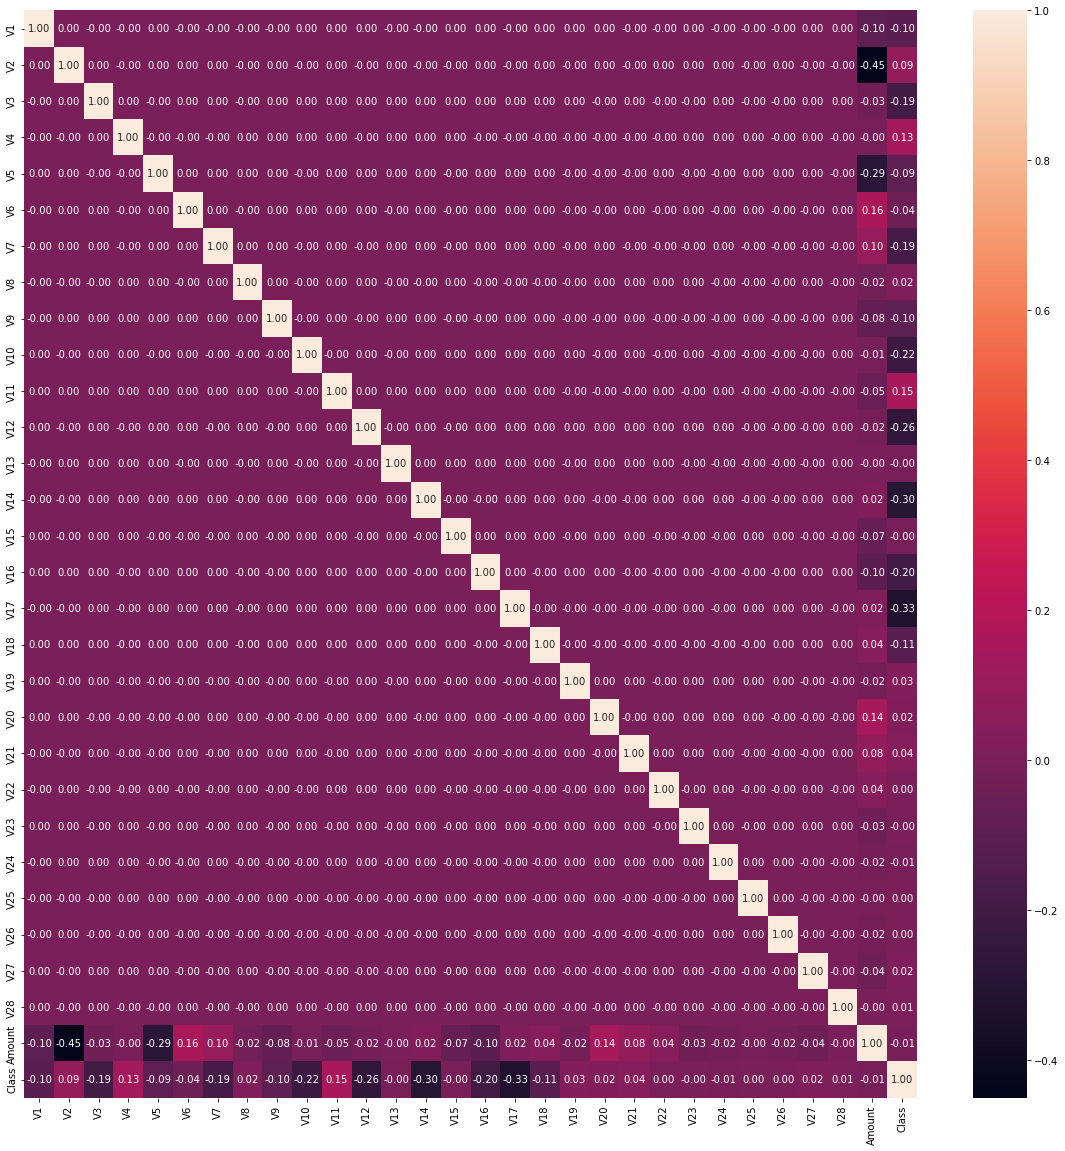

In [43]:
corr = card_df.corr()
plt.figure(figsize=(20, 20))
_ = sns.heatmap(corr, annot=True, fmt=".2f")

In [44]:
out_list = ["V10", "V12", "V14", "V17"]
out_list_index = []

for o in out_list:
    out_list_index.append(get_outlier(card_df, o, weight=1.5))

In [48]:
out_to_del = {key:val for key, val in zip(out_list, out_list_index)}

In [55]:
card_df = pd.read_csv("creditcard.csv")

amount_n = np.log1p(card_df["Amount"])
card_df.drop(columns="Time", axis=1, inplace=True)
for _ in range(0, len(out_list_index)):
    card_df.drop(_, axis=0, inplace=True, errors="ignore")
card_df["Amount"] = amount_n

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199362, 29)
y_train: (199362,)
X_test: (85441, 29)
y_test: (85441,)


In [57]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85289     4]
 [   33   115]]
정확도: 0.9996
정밀도: 0.9664
재현율: 0.7770
F1: 0.8614
ROC_AUC: 0.9805


#### SMOTE 오버 샘플링 적용
SMOTE는 Synthetic Minority Over-sampling Technique의 줄임말로, 합성 소수자 오버 샘플링 기법   
반대로, 언더 샘플리에서는 K-근접 이웃 알고리즘이 많이 사용된다고 함  
학습 데이터에만 적용해야함

In [58]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

display(X_train.shape, y_train.shape)
display(X_train_over.shape, y_train_over.shape)

(199362, 29)

(199362,)

(398036, 29)

(398036,)

In [59]:
y_train.value_counts(normalize=True)

0    0.998274
1    0.001726
Name: Class, dtype: float64

In [60]:
y_train_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: Class, dtype: float64

오버 샘플링 후 비율이 같아진것을 볼 수 있음

In [61]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train_over, X_test, y_train_over, y_test)

[[85281    12]
 [   29   119]]
정확도: 0.9995
정밀도: 0.9084
재현율: 0.8041
F1: 0.8530
ROC_AUC: 0.9779
